In [1]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from utils import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
H = K.constant([[1, 1]])
SNR1 = 7
SNR2 = 7
SNRs = [SNR1, SNR2]
ebno = [calc_ebno(SNR) for SNR in SNRs]

k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel

In [3]:
def TransmissionLayer(x, t, k):
    signal = H[t, k] * x

    for i in range(t):
        if i == k:
            continue
        interference = H[i, k] * x
        signal = signal + interference


#     noise = K.random_normal(K.shape(signal),
#                         mean=0,
#                         stddev=np.sqrt( 1/ (2 * R * ebno[k])))
    return signal 

In [4]:
class AlphaCallback(Callback):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def on_batch_end(self, batch, logs=None):
        loss1, loss2 = logs["decoder1_loss"], logs["decoder2_loss"]
        K.set_value(self.alpha, loss1 / (loss1 + loss2))

In [23]:
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder1")
encoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder2")

combiner = Sequential([
    Dense(n_channel, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="combiner")

signal_input1 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1")

signal_input2 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

decoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder1")

decoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder2")

In [12]:
x1 = encoder1(input_signal1)
x2 = encoder2(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            30          input1[0][0]                     
__________________________________________________________________________________________________
encoder2 (Sequential)           (None, 2)            30          input2[0][0]                     
____________________________________________________________________________________________

In [15]:
train_datas = generate_train_datas()

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha)
])

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2873 - decoder2_loss: 0.2862 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0265 - val_decoder1_loss: 0.0266 - val_decoder2_loss: 0.0265 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2876 - decoder2_loss: 0.2851 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0262 - val_decoder1_loss: 0.0256 - val_decoder2_loss: 0.0268 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.

200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2855 - decoder1_acc: 0.8823 - decoder1_BER: 0.0589 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0268 - val_decoder1_loss: 0.0267 - val_decoder2_loss: 0.0270 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 21/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2864 - decoder2_loss: 0.2889 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0273 - val_decoder1_loss: 0.0265 - val_decoder2_loss: 0.0281 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 22/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2877 - decoder2_loss: 0.2866 - decoder1_acc: 0.8826 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2852 - decoder2_loss: 0.2856 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0268 - val_decoder1_loss: 0.0269 - val_decoder2_loss: 0.0267 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 40/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2875 - decoder2_loss: 0.2847 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0272 - val_decoder1_loss: 0.0272 - val_decoder2_loss: 0.0272 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2859 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2853 - decoder2_loss: 0.2870 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0290 - val_decoder1_loss: 0.0303 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 59/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2866 - decoder2_loss: 0.2844 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8854 - decoder2_BER: 0.0573 - val_loss: 0.0288 - val_decoder1_loss: 0.0299 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 60/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2847 - decoder2_loss: 0.2873 - decoder1_acc: 0.8832 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2856 - decoder2_loss: 0.2866 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0279 - val_decoder1_loss: 0.0282 - val_decoder2_loss: 0.0276 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 78/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2854 - decoder2_loss: 0.2864 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.0278 - val_decoder1_loss: 0.0280 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 79/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2874 - decoder2_loss: 0.2862 - decoder1_acc: 0.8822 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2863 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0281 - val_decoder1_loss: 0.0280 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 97/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2849 - decoder1_loss: 0.2859 - decoder2_loss: 0.2839 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8847 - decoder2_BER: 0.0577 - val_loss: 0.0283 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 98/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2837 - decoder1_loss: 0.2831 - decoder2_loss: 0.2843 - decoder1_acc: 0.8848 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2886 - decoder2_loss: 0.2851 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0282 - val_decoder1_loss: 0.0281 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 116/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2855 - decoder2_loss: 0.2867 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0281 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0279 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 117/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2882 - decoder2_loss: 0.2874 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2853 - decoder1_loss: 0.2849 - decoder2_loss: 0.2856 - decoder1_acc: 0.8839 - decoder1_BER: 0.0581 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0283 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 135/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2852 - decoder2_loss: 0.2865 - decoder1_acc: 0.8829 - decoder1_BER: 0.0586 - decoder2_acc: 0.8825 - decoder2_BER: 0.0587 - val_loss: 0.0284 - val_decoder1_loss: 0.0285 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 136/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2849 - decoder2_loss: 0.2875 - decoder1_acc: 0.8836 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2871 - decoder1_loss: 0.2856 - decoder2_loss: 0.2886 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0285 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 154/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2880 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0284 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 155/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2884 - decoder2_loss: 0.2866 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2852 - decoder1_loss: 0.2862 - decoder2_loss: 0.2842 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 173/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2843 - decoder1_loss: 0.2850 - decoder2_loss: 0.2837 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8845 - decoder2_BER: 0.0578 - val_loss: 0.0285 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0285 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 174/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2863 - decoder2_loss: 0.2857 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2847 - decoder2_loss: 0.2850 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0285 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2869 - decoder2_loss: 0.2846 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2877 - decoder2_loss: 0.2862 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2857 - decoder2_loss: 0.2871 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 211/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2874 - decoder2_loss: 0.2865 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0285 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 212/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2855 - decoder2_loss: 0.2872 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2858 - decoder2_loss: 0.2862 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 230/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2873 - decoder2_loss: 0.2866 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 231/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2868 - decoder2_loss: 0.2864 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2851 - decoder2_loss: 0.2878 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8825 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 249/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2862 - decoder2_loss: 0.2872 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8829 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 250/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2861 - decoder2_loss: 0.2848 - decoder1_acc: 0.8824 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2861 - decoder2_loss: 0.2862 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 268/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2862 - decoder2_loss: 0.2861 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 269/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2869 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2855 - decoder2_loss: 0.2861 - decoder1_acc: 0.8842 - decoder1_BER: 0.0579 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 287/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2855 - decoder2_loss: 0.2882 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 288/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2880 - decoder2_loss: 0.2869 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2874 - decoder2_loss: 0.2871 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 306/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2847 - decoder2_loss: 0.2855 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 307/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2865 - decoder2_loss: 0.2854 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2842 - decoder1_loss: 0.2857 - decoder2_loss: 0.2828 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8843 - decoder2_BER: 0.0578 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 325/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2864 - decoder2_loss: 0.2867 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8844 - decoder2_BER: 0.0578 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 326/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2852 - decoder2_loss: 0.2883 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2884 - decoder2_loss: 0.2832 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8848 - decoder2_BER: 0.0576 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 344/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2867 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 345/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2877 - decoder2_loss: 0.2856 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2845 - decoder1_loss: 0.2838 - decoder2_loss: 0.2853 - decoder1_acc: 0.8852 - decoder1_BER: 0.0574 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 363/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2860 - decoder2_loss: 0.2864 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 364/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2867 - decoder2_loss: 0.2849 - decoder1_acc: 0.8833 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2851 - decoder2_loss: 0.2845 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 382/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2877 - decoder2_loss: 0.2849 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 383/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2880 - decoder2_loss: 0.2864 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2855 - decoder2_loss: 0.2868 - decoder1_acc: 0.8831 - decoder1_BER: 0.0584 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 401/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2882 - decoder1_loss: 0.2886 - decoder2_loss: 0.2879 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 402/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2870 - decoder2_loss: 0.2870 - decoder1_acc: 0.8816 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2867 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0587 - decoder2_acc: 0.8839 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 420/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2876 - decoder2_loss: 0.2864 - decoder1_acc: 0.8833 - decoder1_BER: 0.0583 - decoder2_acc: 0.8837 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 421/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2869 - decoder2_loss: 0.2885 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2870 - decoder2_loss: 0.2874 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 439/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2859 - decoder2_loss: 0.2856 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 440/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2875 - decoder2_loss: 0.2856 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2864 - decoder2_loss: 0.2854 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 458/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2874 - decoder2_loss: 0.2849 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 459/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2853 - decoder2_loss: 0.2870 - decoder1_acc: 0.8833 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2867 - decoder2_loss: 0.2858 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8841 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 477/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2861 - decoder2_loss: 0.2849 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 478/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2868 - decoder2_loss: 0.2862 - decoder1_acc: 0.8827 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2864 - decoder2_loss: 0.2837 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8846 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 496/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2865 - decoder2_loss: 0.2857 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 497/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2852 - decoder1_loss: 0.2860 - decoder2_loss: 0.2843 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2875 - decoder2_loss: 0.2857 - decoder1_acc: 0.8831 - decoder1_BER: 0.0584 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 515/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2888 - decoder2_loss: 0.2847 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 516/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2850 - decoder2_loss: 0.2852 - decoder1_acc: 0.8845 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2872 - decoder2_loss: 0.2837 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 534/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2863 - decoder2_loss: 0.2871 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 535/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2848 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2854 - decoder2_loss: 0.2864 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 553/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2859 - decoder2_loss: 0.2865 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8837 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 554/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2861 - decoder2_loss: 0.2855 - decoder1_acc: 0.8836 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2872 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 572/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2834 - decoder2_loss: 0.2884 - decoder1_acc: 0.8846 - decoder1_BER: 0.0577 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 573/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2866 - decoder2_loss: 0.2859 - decoder1_acc: 0.8830 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2860 - decoder2_loss: 0.2857 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 591/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2868 - decoder2_loss: 0.2873 - decoder1_acc: 0.8825 - decoder1_BER: 0.0588 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 592/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2880 - decoder2_loss: 0.2843 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2843 - decoder2_loss: 0.2883 - decoder1_acc: 0.8842 - decoder1_BER: 0.0579 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 610/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2858 - decoder2_loss: 0.2850 - decoder1_acc: 0.8829 - decoder1_BER: 0.0586 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 611/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2853 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2883 - decoder2_loss: 0.2856 - decoder1_acc: 0.8825 - decoder1_BER: 0.0588 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 629/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2876 - decoder1_loss: 0.2870 - decoder2_loss: 0.2882 - decoder1_acc: 0.8827 - decoder1_BER: 0.0587 - decoder2_acc: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 630/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2855 - decoder2_loss: 0.2847 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2849 - decoder2_loss: 0.2854 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8838 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 648/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2863 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8829 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 649/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2860 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2834 - decoder2_loss: 0.2890 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8823 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 667/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2862 - decoder2_loss: 0.2871 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 668/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2847 - decoder1_loss: 0.2832 - decoder2_loss: 0.2862 - decoder1_acc: 0.8848 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2867 - decoder2_loss: 0.2835 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 686/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2843 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 687/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2882 - decoder2_loss: 0.2867 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2858 - decoder2_loss: 0.2849 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 705/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2860 - decoder2_loss: 0.2851 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 706/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2859 - decoder2_loss: 0.2869 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2848 - decoder2_loss: 0.2867 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 724/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2856 - decoder2_loss: 0.2870 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 725/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2844 - decoder2_loss: 0.2876 - decoder1_acc: 0.8839 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2846 - decoder1_loss: 0.2842 - decoder2_loss: 0.2850 - decoder1_acc: 0.8839 - decoder1_BER: 0.0580 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 743/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2839 - decoder2_loss: 0.2876 - decoder1_acc: 0.8839 - decoder1_BER: 0.0581 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 744/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2873 - decoder1_loss: 0.2875 - decoder2_loss: 0.2869 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2856 - decoder2_loss: 0.2856 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 762/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2844 - decoder1_loss: 0.2836 - decoder2_loss: 0.2851 - decoder1_acc: 0.8850 - decoder1_BER: 0.0575 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 763/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2860 - decoder2_loss: 0.2865 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2859 - decoder2_loss: 0.2859 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 781/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2883 - decoder1_loss: 0.2890 - decoder2_loss: 0.2876 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 782/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2864 - decoder2_loss: 0.2856 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2868 - decoder2_loss: 0.2850 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 800/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2862 - decoder2_loss: 0.2874 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 801/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2850 - decoder2_loss: 0.2861 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2847 - decoder2_loss: 0.2891 - decoder1_acc: 0.8831 - decoder1_BER: 0.0584 - decoder2_acc: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 819/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2891 - decoder2_loss: 0.2864 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 820/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2833 - decoder2_loss: 0.2867 - decoder1_acc: 0.8849 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2852 - decoder2_loss: 0.2880 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 838/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2851 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 839/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2883 - decoder2_loss: 0.2856 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2865 - decoder2_loss: 0.2872 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 857/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2873 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 858/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2845 - decoder2_loss: 0.2866 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2874 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8845 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 876/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2872 - decoder2_loss: 0.2843 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 877/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2872 - decoder2_loss: 0.2866 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2847 - decoder2_loss: 0.2873 - decoder1_acc: 0.8844 - decoder1_BER: 0.0578 - decoder2_acc: 0.8829 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 895/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2871 - decoder1_loss: 0.2869 - decoder2_loss: 0.2872 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 896/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2872 - decoder2_loss: 0.2884 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2848 - decoder2_loss: 0.2877 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8823 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 914/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2881 - decoder1_loss: 0.2893 - decoder2_loss: 0.2869 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 915/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2855 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2865 - decoder2_loss: 0.2861 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8839 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 933/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2872 - decoder2_loss: 0.2852 - decoder1_acc: 0.8825 - decoder1_BER: 0.0588 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 934/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2889 - decoder2_loss: 0.2865 - decoder1_acc: 0.8814 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2851 - decoder2_loss: 0.2885 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 952/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2864 - decoder2_loss: 0.2856 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 953/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2851 - decoder2_loss: 0.2903 - decoder1_acc: 0.8834 - decoder

KeyboardInterrupt: 

# Experiment 2
Train autoencoder first, then train combiner and decoder only

In [5]:
def experiment(seed):
    seed_everything(seed)
    input_signal1 = Input(shape=(M,), name="input1")
    input_signal2 = Input(shape=(M,), name="input2")
    encoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder1")
    encoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder2")

    combiner = Sequential([
        Dense(n_channel, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="combiner")

    signal_input1 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1")

    signal_input2 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

    decoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder1")

    decoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder2")
    x1 = encoder1(input_signal1)
    x1 = signal_input1(x1)
    out1 = decoder1(x1)

    model1 = Model(inputs=input_signal1, outputs=out1)
    alpha = K.variable(.5)

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", BER])
    train_datas = generate_train_datas(k=1)

    model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
        epochs=2000, callbacks=[
        EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
        ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    ])
    
    bers = ber_curve(encoder, decoder1, signal_input1, R = R, SNR_range = [-10, 20], M=M)
    
    return rate_curve([bers], R=R)

In [6]:
hebe = experiment(22)

NameError: name 'encoder' is not defined

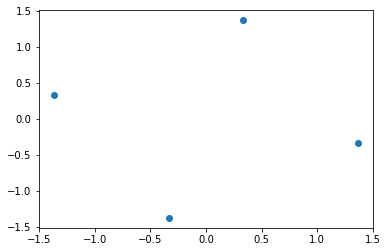

In [41]:
plot_scatter_constellation(encoder1)